In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


import required libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import dataset

In [3]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
# how the data looks like
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Value is: 0')

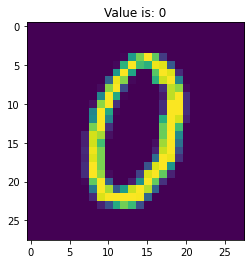

In [5]:
pixel_data=train_df.iloc[:,1:785] 
label=train_df["label"]

number=np.array(pixel_data)
number=number.reshape(len(pixel_data),28,28,1)

plt.imshow(number[5])
plt.title("Value is: %d" % label[5])

setting x as our independent variables and y as our dependent variable

In [6]:
x = train_df.drop(['label'],axis=1)
y = train_df['label']

deep learning performs well on big datasets so importing same dataset of digit from mnist to merge with our current dataset

In [7]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
x_train1=np.concatenate([x_train,x_test],axis=0)
y_train1=np.concatenate([y_train,y_test],axis=0)
x_train2 = x_train1.reshape(-1,28*28)
y_train2= y_train1

In [9]:
x_train3=pd.DataFrame(x_train2,columns=[i for i in x.columns])

concatenating two datasets

In [10]:
x1 = pd.concat([x,x_train3],axis=0,ignore_index=True)
y1 = pd.concat([y,pd.DataFrame(y_train2)],axis=0,ignore_index=True)

Scaling the values of independent variables(x)

In [11]:
x1 = x1/255.0

In [12]:
x1=np.array(x1).reshape(-1,28,28,1)

In [13]:
# one-hot-encoding
y1=np.array(to_categorical(y1, num_classes=10))

In [14]:
x_tr,x_tt,y_tr,y_tt = train_test_split(x1,y1,test_size=0.2,random_state=42)

model implementation

In [15]:
model = Sequential()

2023-02-14 18:09:47.493193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 18:09:47.494219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 18:09:47.754758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 18:09:47.755618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 18:09:47.756381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [16]:
model.add(Conv2D(input_shape=(28,28,1),filters=32,kernel_size=(5,5),padding="same",
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.10))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Dropout(0.10))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.10))

model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu',padding="same",kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),padding="same"))
model.add(Dropout(0.20))

model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu',padding="valid"))
model.add(BatchNormalization())
model.add(Dropout(0.20))

model.add(Conv2D(filters=256,kernel_size=(2,2),activation='relu',padding="valid",kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(2,2),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Dropout(0.20))

model.add(Conv2D(filters=512,kernel_size=(2,2),activation='relu',padding="valid",kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256,activation='elu',
                kernel_regularizer=tensorflow.keras.regularizers.L2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128,activation='elu',
                kernel_regularizer=tensorflow.keras.regularizers.L2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64,activation='elu',
                kernel_regularizer=tensorflow.keras.regularizers.L2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(32,activation='elu',
                kernel_regularizer=tensorflow.keras.regularizers.L2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(10,activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0

In [18]:
model.compile(optimizer= 'RMSprop',loss='categorical_crossentropy',metrics=['accuracy'],)

In [19]:
# data augmentation
ImageDataGenerator = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,
                                        height_shift_range=0.1,zoom_range=0.1,
                                        shear_range=0.15)

In [20]:
# reducing learning rate as getting closer to minima
learning_rate_reducer = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='auto',min_lr=0.0001)

In [21]:
x_test.shape

(10000, 28, 28)

In [22]:
ImageDataGenerator.fit(x_tr)
model.fit_generator(ImageDataGenerator.flow(x_tr,y_tr,batch_size=256),epochs=30,
                    steps_per_epoch=x_tr.shape[0] //256,callbacks=learning_rate_reducer,
                    validation_data=(x_tt,y_tt))

2023-02-14 18:09:53.311181: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-14 18:09:58.309385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


350/350 [==============================] - 48s 91ms/step - loss: 1.2050 - accuracy: 0.9145 - val_loss: 0.8581 - val_accuracy: 0.8553
Epoch 2/30
350/350 [==============================] - 31s 89ms/step - loss: 0.3609 - accuracy: 0.9707 - val_loss: 0.3058 - val_accuracy: 0.9595
Epoch 3/30
350/350 [==============================] - 31s 88ms/step - loss: 0.2247 - accuracy: 0.9755 - val_loss: 0.1945 - val_accuracy: 0.9779
Epoch 4/30
350/350 [==============================] - 31s 88ms/step - loss: 0.1825 - accuracy: 0.9785 - val_loss: 0.1306 - val_accuracy: 0.9903
Epoch 5/30
350/350 [==============================] - 31s 88ms/step - loss: 0.1581 - accuracy: 0.9805 - val_loss: 0.1245 - val_accuracy: 0.9882
Epoch 6/30
350/350 [==============================] - 31s 88ms/step - loss: 0.1445 - accuracy: 0.9823 - val_loss: 0.1341 - val_accuracy: 0.9851
Epoch 7/30
350/350 [==============================] - 30s 87ms/step - loss: 0.1372 - accuracy: 0.9832 - val_loss: 0.0980 - val_accuracy: 0.9926
Epo

In [23]:
# predict results
test_df = test_df/255
test_df=np.array(test_df).reshape(-1,28,28,1)
results = model.predict(test_df)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("sample_submission.csv",index=False)